This notebook explores the parks that are beyond the DC-metro area boarder, identifies them, and explores how to deal with the one park that is within and without the boarder

In [ ]:
!pip install osmnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.2/107.2 kB 3.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import geopandas
import folium
import numpy as np
from pyproj import Geod
import warnings
warnings.filterwarnings('ignore')

In [ ]:
places = ["Washington, DC, USA", "Arlington, Virginia, USA", "Alexandria, Virginia, USA"] #Our places of interest. This cell has about a 3m runtime
graphs = [ox.graph_from_place(place, network_type='walk') for place in places]
G_combined = nx.compose_all(graphs)

In [ ]:
#Tags we're using
greenspace_tags = {'leisure': ['park', 'garden', 'nature_reserve']}

# Function to get nodes from a place based on tags
def get_nodes_from_place(place, tags):
    return ox.features_from_place(place, tags)

# Function to put tag's lat/longs in a list
# Coords outputs Point locaitons (for metro)
# Nodes_combined outputs a dataframe with Points/Polygons/Multipolygon geometric objects (for greenspaces)
def get_lat_longs(tags):
  nodes = []
  for place in places:
    nodes.append(get_nodes_from_place(place, tags))
  nodes_combined = pd.concat(nodes)
  coords = nodes_combined[nodes_combined.geom_type == 'Point'].geometry.apply(lambda geom: (geom.y, geom.x)).tolist()
  return coords, nodes_combined

#call the function for each group
greenspace_coords, nodes_combined_green = get_lat_longs(greenspace_tags)

In [ ]:
#clean nodes_combined_green
nodes_combined_green=nodes_combined_green[['geometry','leisure']]

#remove Point parks
nodes_combined_green=nodes_combined_green[nodes_combined_green.geom_type.isin(['Polygon', 'MultiPolygon'])]
print(len(nodes_combined_green))

#add center coords
nodes_combined_green['centercoords'] = nodes_combined_green.geometry.apply(lambda geom: (geom.centroid.y, geom.centroid.x)).tolist()

#clean the greenspace nodes combined dataframe
nodes_combined_green.reset_index(drop=True, inplace=True)

2159


In [ ]:
#Add area to nodes_combined_green using geodesic area

geod = Geod(ellps="WGS84")
area_sqmeters = []

for x in range(0, len(nodes_combined_green)):
  poly= nodes_combined_green.geometry[x]
  geod_area = abs(geod.geometry_area_perimeter(poly)[0])
  area_sqmeters.append(geod_area)

nodes_combined_green['area_sq'] = area_sqmeters

In [ ]:
nodes_combined_green.head()

geometry leisure  \
0  POLYGON ((-77.00215 38.88420, -77.00344 38.884...    park   
1  POLYGON ((-77.01015 38.89226, -77.01016 38.892...    park   
2  POLYGON ((-77.00987 38.89220, -77.00983 38.892...    park   
3  POLYGON ((-77.00889 38.89508, -77.00889 38.895...    park   
4  POLYGON ((-77.00695 38.89485, -77.00612 38.894...    park   

                              centercoords       area_sq  
0   (38.88376610180733, -77.0027918516593)  10959.130584  
1  (38.89272265443145, -77.01111066281618)  18375.057990  
2  (38.893524380409424, -77.0089392440881)  58859.658338  
3  (38.89534501714227, -77.00778205019144)  14269.138485  
4  (38.89527091749446, -77.00645010025782)   7780.460021

In [ ]:
m = folium.Map(location=[38.9, -77], zoom_start=12)
folium.GeoJson(nodes_combined_green["geometry"]).add_to(m)
#folium.GeoJson(nodes_combined_green["geometry"].apply(lambda x: x.centroid)).add_to(m)
m

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


As can be seen there are several parks where the area includes a considerable amount of area outside the dc-metro area. We should look to remove or alter these parks so they do not affect the model as outliers

In [ ]:
nodes_combined_green.nlargest(20, 'area_sq')

geometry         leisure  \
1685  MULTIPOLYGON (((-77.16941 38.97027, -77.16933 ...  nature_reserve   
1726  MULTIPOLYGON (((-77.15051 39.16578, -77.15100 ...  nature_reserve   
1677  POLYGON ((-77.05449 38.98540, -77.05359 38.986...            park   
1696  MULTIPOLYGON (((-76.94155 38.91823, -76.93845 ...  nature_reserve   
1703  MULTIPOLYGON (((-77.05595 38.89403, -77.05546 ...            park   
1695  MULTIPOLYGON (((-77.02585 38.79366, -77.02595 ...            park   
1729  MULTIPOLYGON (((-76.95627 38.94919, -76.95618 ...  nature_reserve   
637   POLYGON ((-76.95478 38.91208, -76.95539 38.911...            park   
1670  MULTIPOLYGON (((-76.96215 38.90614, -76.96228 ...            park   
1733  MULTIPOLYGON (((-76.95974 38.88065, -76.96138 ...            park   
1667  MULTIPOLYGON (((-77.03851 38.87919, -77.03818 ...            park   
1964  MULTIPOLYGON (((-77.48746 39.04407, -77.48748 ...            park   
1668  MULTIPOLYGON (((-77.05595 38.89403, -77.05546 ...            park   
1669  MULTIPOLYGON (((-77.08230 38.91842, -77.08184 ...            park   
85    POLYGON ((-77.05710 38.90408, -77.05711 38.904...            park   
147   POLYGON ((-76.97361 38.88028, -76.97349 38.880...            park   
1724  POLYGON ((-77.04481 38.83473, -77.04433 38.833...            park   
2158  POLYGON ((-77.04481 38.83473, -77.04433 38.833...            park   
1671  MULTIPOLYGON (((-77.01763 38.82831, -77.01747 ...            park   
1972  MULTIPOLYGON (((-77.12748 38.86804, -77.12730 ...  nature_reserve   

                                  centercoords       area_sq  
1685    (39.3764902415827, -77.84226274867629)  5.967829e+07  
1726   (39.07623448688934, -77.10207642383152)  7.867465e+06  
1677    (38.96275342556925, -77.0461151618257)  7.170313e+06  
1696   (39.02539907910802, -76.85486840747002)  5.779278e+06  
1703   (38.88798790895951, -77.03375895871955)  3.011375e+06  
1695   (38.80486952570417, -77.01315569810518)  2.353788e+06  
1729    (38.9455934174271, -76.93574803975449)  2.118133e+06  
637   (38.911573478721174, -76.96580865267177)  1.829623e+06  
1670   (38.90959391429277, -76.94989542587477)  1.559090e+06  
1733    (38.87758046002944, -76.9500194586984)  1.539541e+06  
1667   (38.87136646595192, -77.02782569114962)  1.374784e+06  
1964    (38.96333729414098, -77.3539235001025)  1.127173e+06  
1668   (38.88816114019179, -77.04636148749246)  9.792363e+05  
1669    (38.92328049551966, -77.0819492300392)  9.628171e+05  
85      (38.91434249901701, -77.0538504841895)  7.338955e+05  
147   (38.890715274584466, -76.97077535895173)  6.757476e+05  
1724    (38.82936993300502, -77.0418905387882)  6.170203e+05  
2158    (38.82936993300502, -77.0418905387882)  6.170203e+05  
1671   (38.83804054046756, -77.00885208714614)  5.864212e+05  
1972   (38.86231692761927, -77.11915673376518)  5.417379e+05

In [ ]:
m = folium.Map(location=[38.9, -77], zoom_start=12)
folium.GeoJson(nodes_combined_green.nlargest(20, 'area_sq')['geometry']).add_to(m)
m

Polygons with index: 1685, 1726, 1696, 1729, 1964, were determined to be the largest offenders

In [ ]:
m = folium.Map(location=[38.9, -77], zoom_start=12)
folium.GeoJson(nodes_combined_green.iloc[1685,0]).add_to(m)
folium.GeoJson(nodes_combined_green.iloc[1726,0]).add_to(m)
folium.GeoJson(nodes_combined_green.iloc[1696,0]).add_to(m)
folium.GeoJson(nodes_combined_green.iloc[1729,0]).add_to(m)
folium.GeoJson(nodes_combined_green.iloc[1964,0]).add_to(m)
m

Polygon 1726, 1696, 1729, and 1964 can be removed easily without, because the start of the park is outside our area of interest. However, Polygon 1685 should be considered in our dataset, because it takes up a large amount of area inside DC. Though it should not have an area of 5.967829e+07 Square Meters

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
geom=nodes_combined_green.iloc[1685,0]
mycoordslist = [list(x.exterior.coords) for x in geom.geoms]

In [ ]:
mycoordslist

[[(-77.1694118, 38.9702673),
  (-77.169331, 38.9702231),
  (-77.1691819, 38.9702054),
  (-77.1688938, 38.9702074),
  (-77.1686575, 38.9702605),
  (-77.1682582, 38.970343),
  (-77.1677326, 38.9704226),
  (-77.1671412, 38.9705542),
  (-77.1670452, 38.9705866),
  (-77.1669555, 38.9706141),
  (-77.166886, 38.9706436),
  (-77.1668911, 38.9706544),
  (-77.1670578, 38.9706721),
  (-77.1673977, 38.9707359),
  (-77.1677389, 38.9707693),
  (-77.1680851, 38.9707644),
  (-77.1686107, 38.9707271),
  (-77.169144, 38.9706681),
  (-77.1694674, 38.9706485),
  (-77.1695268, 38.9706387),
  (-77.1695913, 38.9706102),
  (-77.1695938, 38.9705562),
  (-77.169566, 38.9704864),
  (-77.1694712, 38.9703587),
  (-77.1694118, 38.9702673)],
 [(-77.2495596, 39.0006224),
  (-77.2495356, 39.0007314),
  (-77.249528, 39.0008885),
  (-77.2495381, 39.0010162),
  (-77.249552, 39.0011645),
  (-77.2496038, 39.0013559),
  (-77.249619, 39.0014797),
  (-77.2496417, 39.0015582),
  (-77.2496847, 39.0016063),
  (-77.2497529, 39.00

The following point: (38.935649, -77.118427) is on the DC/Maryland boarder on the North West side on the Potomic River. Park 1685 should not cross this point. We should eliminate any lonitude that is west of -77.118427

In [ ]:
newcoordslist = []
for coords in mycoordslist:
  lst1 = []
  for coord in coords:
    if coord[0] > -77.118427:
      lst1.append(coord)
  newcoordslist.append(lst1)

In [ ]:
for coords in newcoordslist:
  print(len(coords))

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
733
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
29


In [ ]:
newcoordslist = [x for x in newcoordslist if x != []]

In [ ]:
for coords in newcoordslist:
  print(len(coords))

733
29


In [ ]:
# convert newcoordslist back into a multipolygon

from shapely.geometry import Polygon, MultiPolygon
# Recreate the polygons
polygons = [Polygon(coords) for coords in newcoordslist]

# Create a MultiPolygon from the polygons
multipolygon = MultiPolygon(polygons)

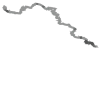

In [ ]:
nodes_combined_green.iloc[1685,0]

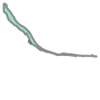

In [ ]:
multipolygon

In [ ]:
m = folium.Map(location=[38.9, -77], zoom_start=12)
folium.GeoJson(multipolygon).add_to(m)
m

In [ ]:
nodes_combined_green.iloc[1685,0] = multipolygon

In [ ]:
nodes_combined_green.drop(nodes_combined_green.index[[1726, 1696, 1729, 1964]], inplace=True)
print(len(nodes_combined_green))

2155


In [ ]:
m = folium.Map(location=[38.9, -77], zoom_start=12)
folium.GeoJson(nodes_combined_green["geometry"]).add_to(m)
#folium.GeoJson(nodes_combined_green["geometry"].apply(lambda x: x.centroid)).add_to(m)
m